In [30]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup = data.iloc[3524:]

data = data.iloc[:3524]
data_copy = data.copy()

print('Data imported and copied.', flush=True)

Data imported and copied.


In [31]:
import numpy as np

## Creating sequences
def create_dataset(dataset, time_step=1, output_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-output_step):
        a = dataset[i:(i+time_step), 0]
        b = dataset[(i+time_step):(i+time_step)+output_step, 0]
        dataX.append(a)
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

period = 60
trend_period = 14
rsi_period = 14
num_features = 3
input_period = 46
output_step = 7
units = 512

In [32]:
X, y = create_dataset(data[['close']].to_numpy(), time_step=period, output_step=output_step)

In [33]:
data_input = np.array([np.concatenate((X[i], y[i]), axis=0) for i in range(X.shape[0])])

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions = np.array([seasonal_decompose(data_input[i], model='additive', period=14) for i in range(data_input.shape[0])])
trends = np.array([decompositions[i].trend for i in range(decompositions.shape[0])])
seasons = np.array([decompositions[i].seasonal for i in range(decompositions.shape[0])])

In [35]:
from talib import RSI

rsi = np.array([ RSI(data_input[i]) for i in range(data_input.shape[0]) ])

In [36]:
trends_dropna = list()
seasons_cropped = list()
rsi_dropna = list()

for trend in trends:
    trends_dropna.append(trend[~np.isnan(trend)])

for season in seasons:
    #seasons_cropped.append(season[int(trend_period/2):-int(trend_period/2)])
    seasons_cropped.append(season[trend_period:])

for r in rsi:
    #rsi_dropna.append(r[-53:])
    rsi_dropna.append(r[rsi_period:])

trends_dropna = np.array(trends_dropna)
seasons_cropped = np.array(seasons_cropped)
rsi_dropna = np.array(rsi_dropna)

In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = list(MinMaxScaler() for i in range(trends_dropna.shape[0]))
trends_scaled = list()

scaler_seasonal = list(MinMaxScaler() for i in range(seasons_cropped.shape[0]))
seasons_scaled = list()

scaler_rsi = list(MinMaxScaler() for i in range(rsi_dropna.shape[0]))
rsi_scaled = list()

for i in range(trends_dropna.shape[0]):
    trends_scaled.append(scaler[i].fit_transform(trends_dropna[i].reshape(-1,1)))

for i in range(seasons_cropped.shape[0]):
    seasons_scaled.append(scaler_seasonal[i].fit_transform(seasons_cropped[i].reshape(-1,1)))

for i in range(rsi_dropna.shape[0]):
    rsi_scaled.append(scaler_rsi[i].fit_transform(rsi_dropna[i].reshape(-1,1)))

trends_scaled = np.array(trends_scaled)
seasons_scaled = np.array(seasons_scaled)
rsi_scaled = np.array(rsi_scaled)

In [38]:
X_input = list()
y_input = list()

for trend, season, rsi in zip(trends_scaled, seasons_scaled, rsi_scaled):
    X_input.append(np.hstack((trend[:trend.shape[0]-7], season[:season.shape[0]-7], rsi[:rsi.shape[0]-7])))
    y_input.append(trend[trend.shape[0]-7:])

X_input = np.array(X_input)
y_input = np.array(y_input)

In [39]:
X_input.shape

(3457, 46, 3)

# **Main Model**

In [40]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Conv1D, AveragePooling1D, Flatten, Reshape, SimpleRNN, GRU, MaxPooling1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Zeros

inputs = Input(shape=(input_period, num_features))

model_cnn = Sequential([
    Conv1D(filters=352, kernel_size=1, activation='relu'),
    Conv1D(filters=352, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=3),
    Dense(units=128),
    Flatten()
    #Dense(units=output_step),
    #Reshape((output_step,1))
])

model_bilstm = Sequential([
    Bidirectional(LSTM(units=384, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')),
    Dropout(0.2),
    Flatten()
    #Dense(units=output_step),
    #Reshape((output_step,1))
])

model_bigru = Sequential([
    Bidirectional(GRU(units=128, activation='tanh', return_sequences=True)),
    Dropout(0.4),
    Flatten()
])

model_multilayer_lstm = Sequential([
    LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Dropout(0.2),
    LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Flatten()
])

In [41]:
output_cnn = model_cnn(inputs)
output_bilstm = model_bilstm(inputs)
output_bigru = model_bigru(inputs)
output_multilayer_lstm = model_multilayer_lstm(inputs)

concatenated_outputs = concatenate([output_cnn, output_bilstm, output_bigru, output_multilayer_lstm])

main_model = Sequential([
    Input(shape=(concatenated_outputs.shape[1],)),
    Dense(units=output_step),
    Reshape((output_step,1))
])

final_output = main_model(concatenated_outputs)

functional_pipeline = Model(inputs=inputs, outputs=final_output)

In [13]:
X_input.shape

(3457, 46, 3)

In [14]:
# Compile the pipeline model
functional_pipeline.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='model_weights_6_3_main/model_weights_epoch_{epoch:02d}.h5', 
                            save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the pipeline model
history = functional_pipeline.fit(X_input, y_input, epochs=150, batch_size=64, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/150
44/44 [==============================] - 52s 873ms/step - loss: 0.1362 - accuracy: 0.0761 - val_loss: 0.0268 - val_accuracy: 0.0842
Epoch 2/150
44/44 [==============================] - 39s 882ms/step - loss: 0.0217 - accuracy: 0.0862 - val_loss: 0.0205 - val_accuracy: 0.0844
Epoch 3/150
44/44 [==============================] - 37s 838ms/step - loss: 0.0172 - accuracy: 0.0867 - val_loss: 0.0166 - val_accuracy: 0.0851
Epoch 4/150
44/44 [==============================] - 35s 791ms/step - loss: 0.0150 - accuracy: 0.0870 - val_loss: 0.0129 - val_accuracy: 0.0853
Epoch 5/150
44/44 [==============================] - 37s 854ms/step - loss: 0.0137 - accuracy: 0.0868 - val_loss: 0.0114 - val_accuracy: 0.0855
Epoch 6/150
44/44 [==============================] - 36s 828ms/step - loss: 0.0124 - accuracy: 0.0870 - val_loss: 0.0115 - val_accuracy: 0.0857
Epoch 7/150
44/44 [==============================] - 35s 803ms/step - loss: 0.0124 - accuracy: 0.0872 - val_loss: 0.0150 - val_accuracy:

In [13]:
# Select the epoch
best_epoch = np.argmin(history.history['val_loss'])
best_epoch = best_epoch+1
print(f'best result is for epoch number {best_epoch}')

# Load the weights of the model at the chosen epoch
functional_pipeline.load_weights(f'model_weights_6_3_main/model_weights_epoch_{best_epoch:02d}.h5')
print('Weigths for the best epoch has been loaded.')

NameError: name 'history' is not defined

In [42]:
best_epoch_backup = 35

# Load the weights of the model at the chosen epoch
functional_pipeline.load_weights(f'model_weights_6_3_main/model_weights_epoch_{best_epoch_backup:02d}.h5')
print('Backup: Weigths for the best epoch has been loaded.')

Backup: Weigths for the best epoch has been loaded.


## Data testing

In [43]:
#data_backup = pd.read_csv('data/^NDX_raw_data.csv')
data_backup = pd.read_csv('data-china-from2018-test/000001.SS_raw_data.csv')
data_backup.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup_copy = data_backup.copy()

In [44]:
X_test, y_test = create_dataset(data_backup[['close']].to_numpy(), time_step=period, output_step=output_step)

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions_test = np.array([seasonal_decompose(X_test[i], model='additive', period=14) for i in range(X_test.shape[0])])
trends_test = np.array([decompositions_test[i].trend for i in range(decompositions_test.shape[0])])
seasons_test = np.array([decompositions_test[i].seasonal for i in range(decompositions_test.shape[0])])

In [46]:
from talib import RSI

rsi_test = np.array([ RSI(X_test[i]) for i in range(X_test.shape[0]) ])

In [47]:
trends_dropna_test = list()
seasons_cropped_test = list()
rsi_dropna_test = list()

for trend in trends_test:
    trends_dropna_test.append(trend[~np.isnan(trend)])

for season in seasons_test:
    seasons_cropped_test.append(season[trend_period:])

for rsi in rsi_test:
    rsi_dropna_test.append(rsi[rsi_period:])

trends_dropna_test = np.array(trends_dropna_test)
seasons_cropped_test = np.array(seasons_cropped_test)
rsi_dropna_test = np.array(rsi_dropna_test)

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler_test = list(MinMaxScaler() for i in range(trends_dropna_test.shape[0]))
trends_scaled_test = list()

scaler_seasonal_test = list(MinMaxScaler() for i in range(seasons_cropped_test.shape[0]))
seasons_scaled_test = list()

scaler_rsi_test = list(MinMaxScaler() for i in range(rsi_dropna_test.shape[0]))
rsi_scaled_test = list()

for i in range(trends_dropna_test.shape[0]):
    trends_scaled_test.append(scaler_test[i].fit_transform(trends_dropna_test[i].reshape(-1,1)))

for i in range(seasons_cropped_test.shape[0]):
    seasons_scaled_test.append(scaler_seasonal_test[i].fit_transform(seasons_cropped_test[i].reshape(-1,1)))

for i in range(rsi_dropna_test.shape[0]):
    rsi_scaled_test.append(scaler_rsi_test[i].fit_transform(rsi_dropna_test[i].reshape(-1,1)))

trends_scaled_test = np.array(trends_scaled_test)
seasons_scaled_test = np.array(seasons_scaled_test)
rsi_scaled_test = np.array(rsi_scaled_test)

In [49]:
X_input_test = list()
#y_input = list()

for trend, season, rsi in zip(trends_scaled_test, seasons_scaled_test, rsi_scaled_test):
    X_input_test.append(np.hstack((trend, season, rsi)))
    #y_input.append(trend[trend.shape[0]-7:])

X_input_test = np.array(X_input_test)
#y_input = np.array(y_input)

In [50]:
# Prepare reference y_test
test_input = np.array([np.concatenate((X_test[i], y_test[i]), axis=0) for i in range(X_test.shape[0])])

decompose_test_input = np.array([seasonal_decompose(test_input[i], model='additive', period=14) for i in range(X_test.shape[0])])
trends_test_input = np.array([decompose_test_input[i].trend for i in range(decompose_test_input.shape[0])])

trends_test_input_dropna = list()
for trend in trends_test_input:
    trends_test_input_dropna.append(trend[~np.isnan(trend)])

trends_test_input_dropna = np.array(trends_test_input_dropna)

y_input = list()
for trend in trends_test_input_dropna:
    y_input.append(trend[trend.shape[0]-7:])

y_input = np.array(y_input)

In [51]:
trend_predictions_test = list()

for j in range(X_input_test.shape[0]):
    if (j+1) % 100 == 0:
        print(j+1)
        
    trend_predictions_test.append(
        scaler_test[j].inverse_transform(
            functional_pipeline.predict(X_input_test[j].reshape(trends_scaled_test[j].shape[1], input_period, num_features), verbose=0)[0].reshape(1,output_step)
        )
    )

trend_predictions_test = np.array(trend_predictions_test)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [52]:
# Logistic transformation
def logistic_transform(r2):
    return round(1 / (1 + np.exp(-r2)),2)
        
def report_score(outputs):
    from sklearn.metrics import r2_score
    
    pred, y = outputs
    
    try:
        assert pred.shape[2] == output_step
        assert y.shape[1] == output_step

        _pred = pred.reshape(-1, output_step)
        _y = y.reshape(-1, output_step)
    
        res = list()
        for i in range(_pred.shape[0]):
            res.append(r2_score(_y[i], _pred[i]))

        res = np.array(res)
    
        return {
            'mean_score': np.mean(res),
            'max_score': res.max(),
            'min_score': res.min(),
            'logistic_score': logistic_transform(np.mean(res))
        }
    except:
        print("Array shapes don't match")

In [53]:
report_score((trend_predictions_test, y_input))

{'mean_score': -12.854873470538207,
 'max_score': 0.9911928050452281,
 'min_score': -1016.2387212517358,
 'logistic_score': 0.0}

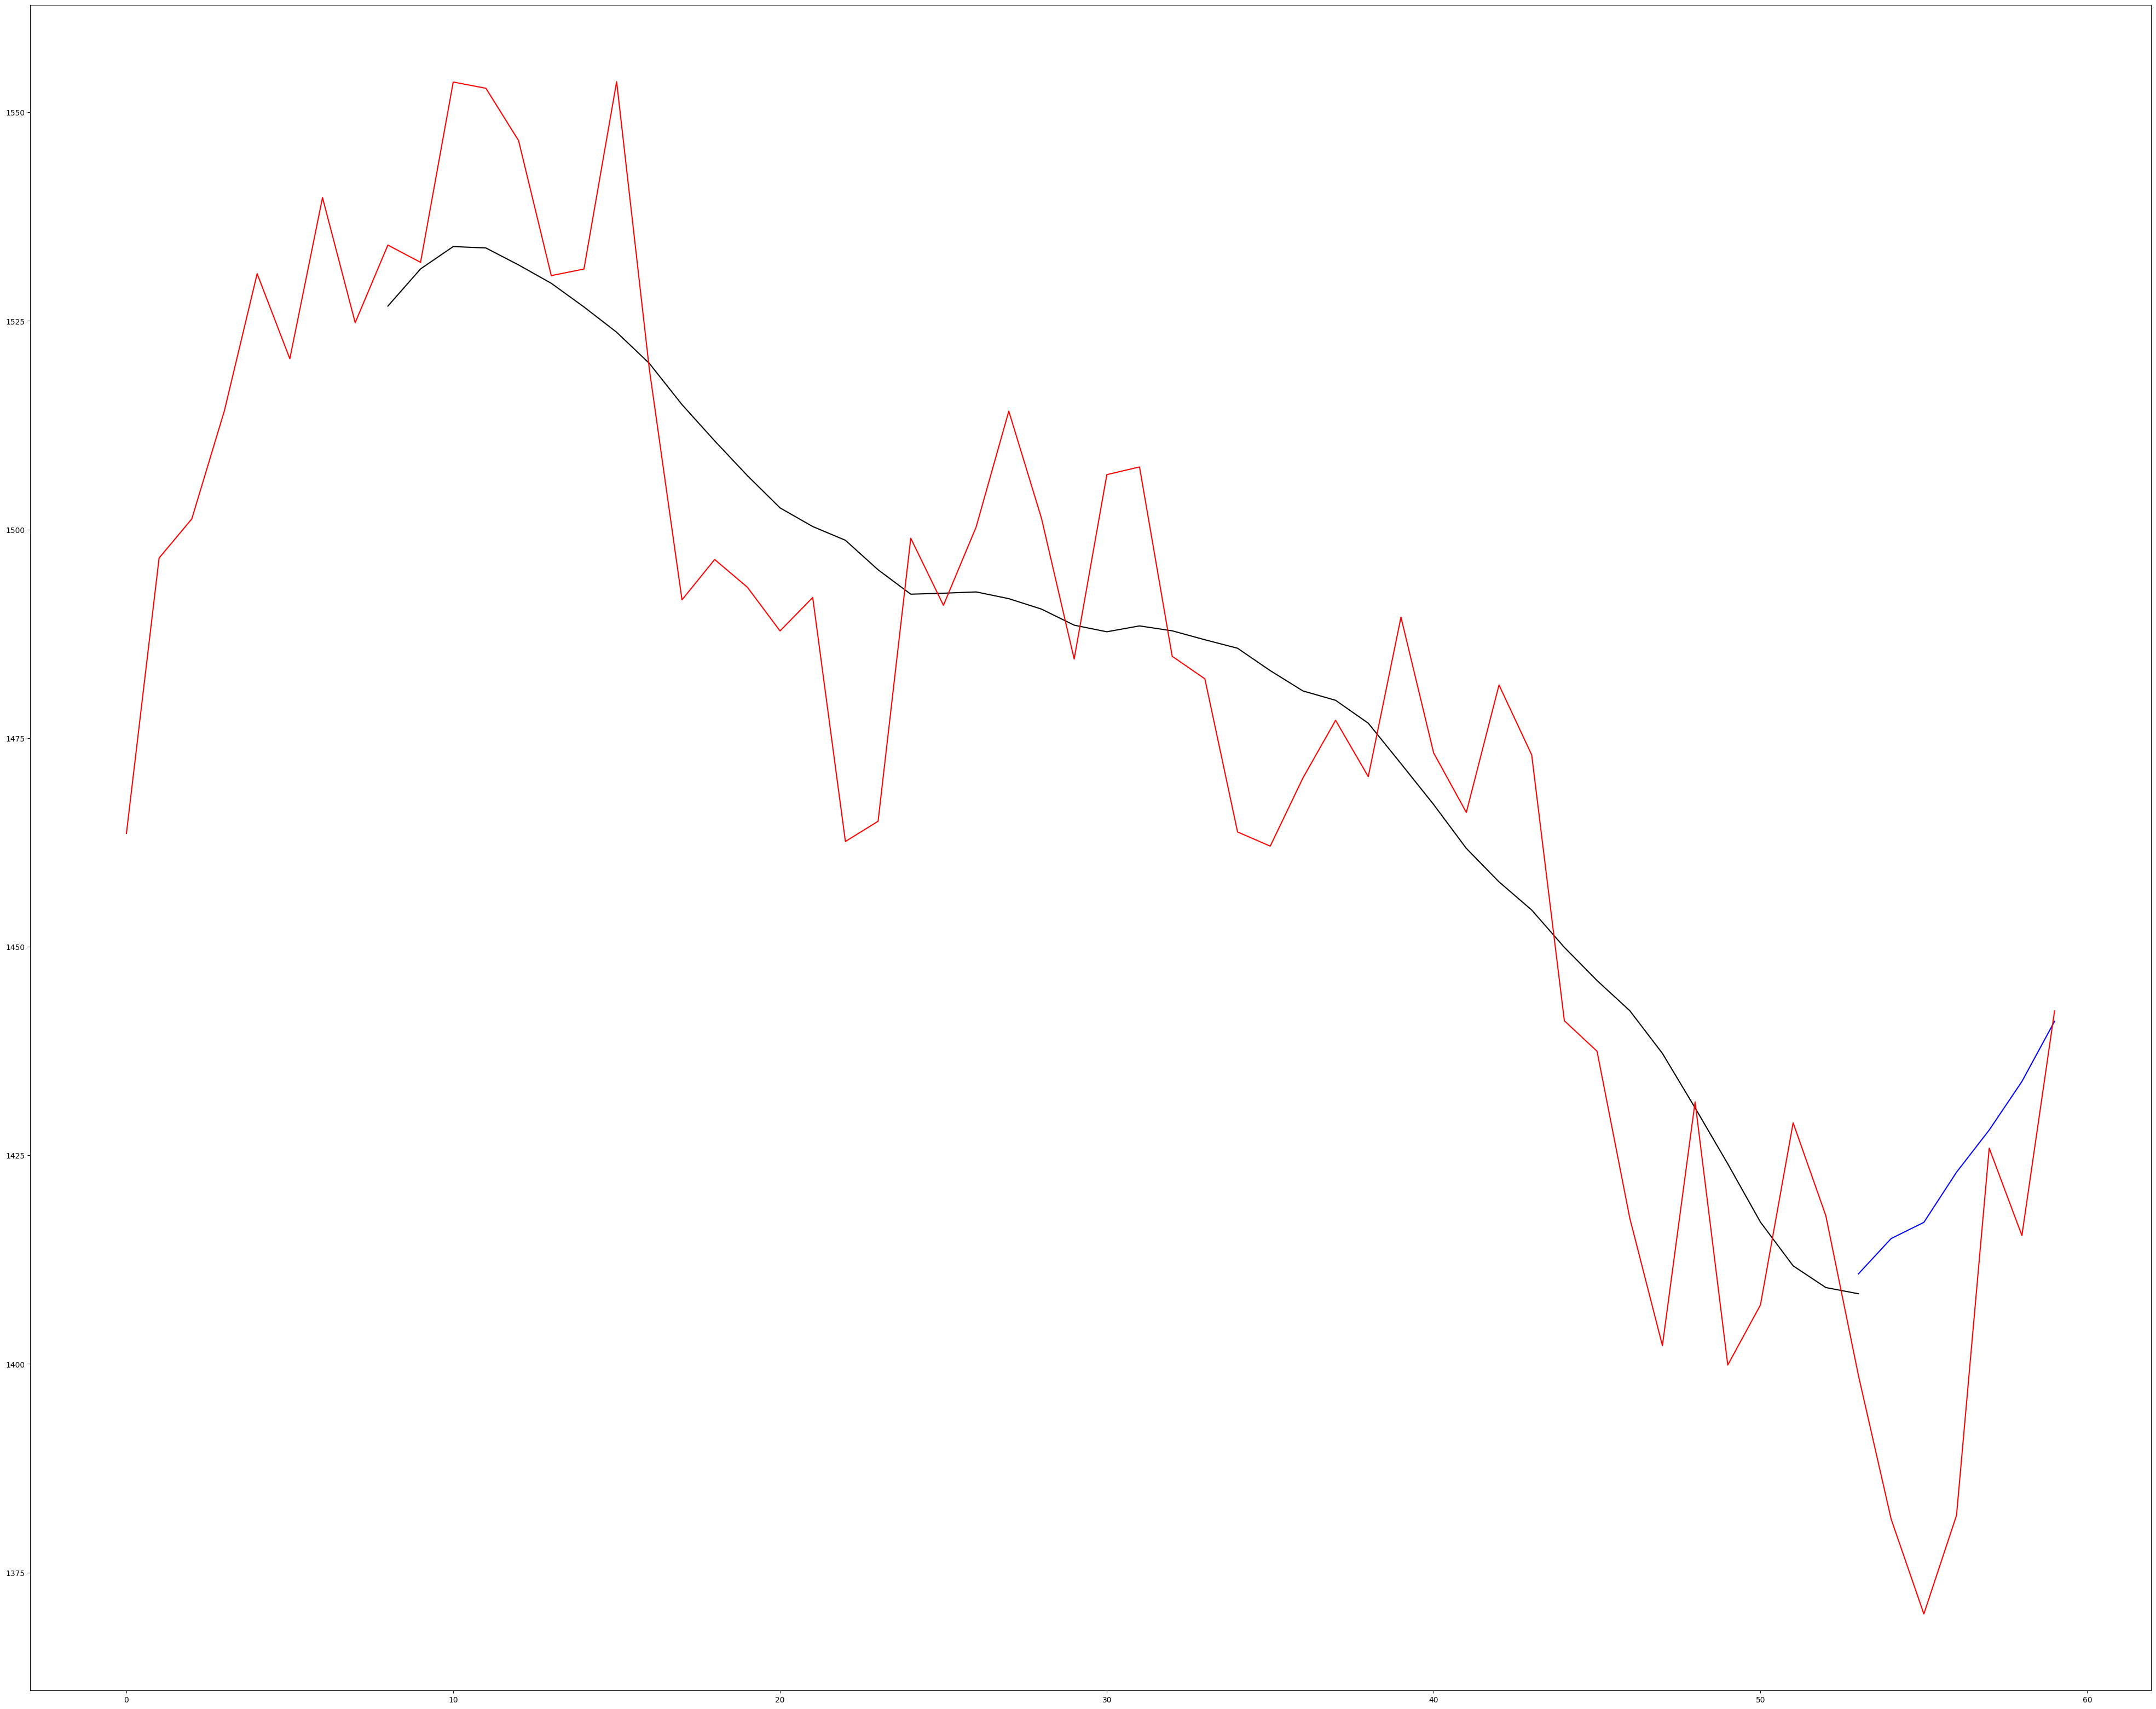

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

plt.plot(data_backup.index[53:60], trend_predictions_test[0][0], color='blue')
plt.plot(data_backup.index[8:54], trends_dropna_test[0], color='black')
plt.plot(data_backup.index[:60], data_backup['close'].iloc[:60], color='red')

In [25]:
trends_test_df = pd.DataFrame(trends_dropna_test, index=data_backup.index[output_step:-period])

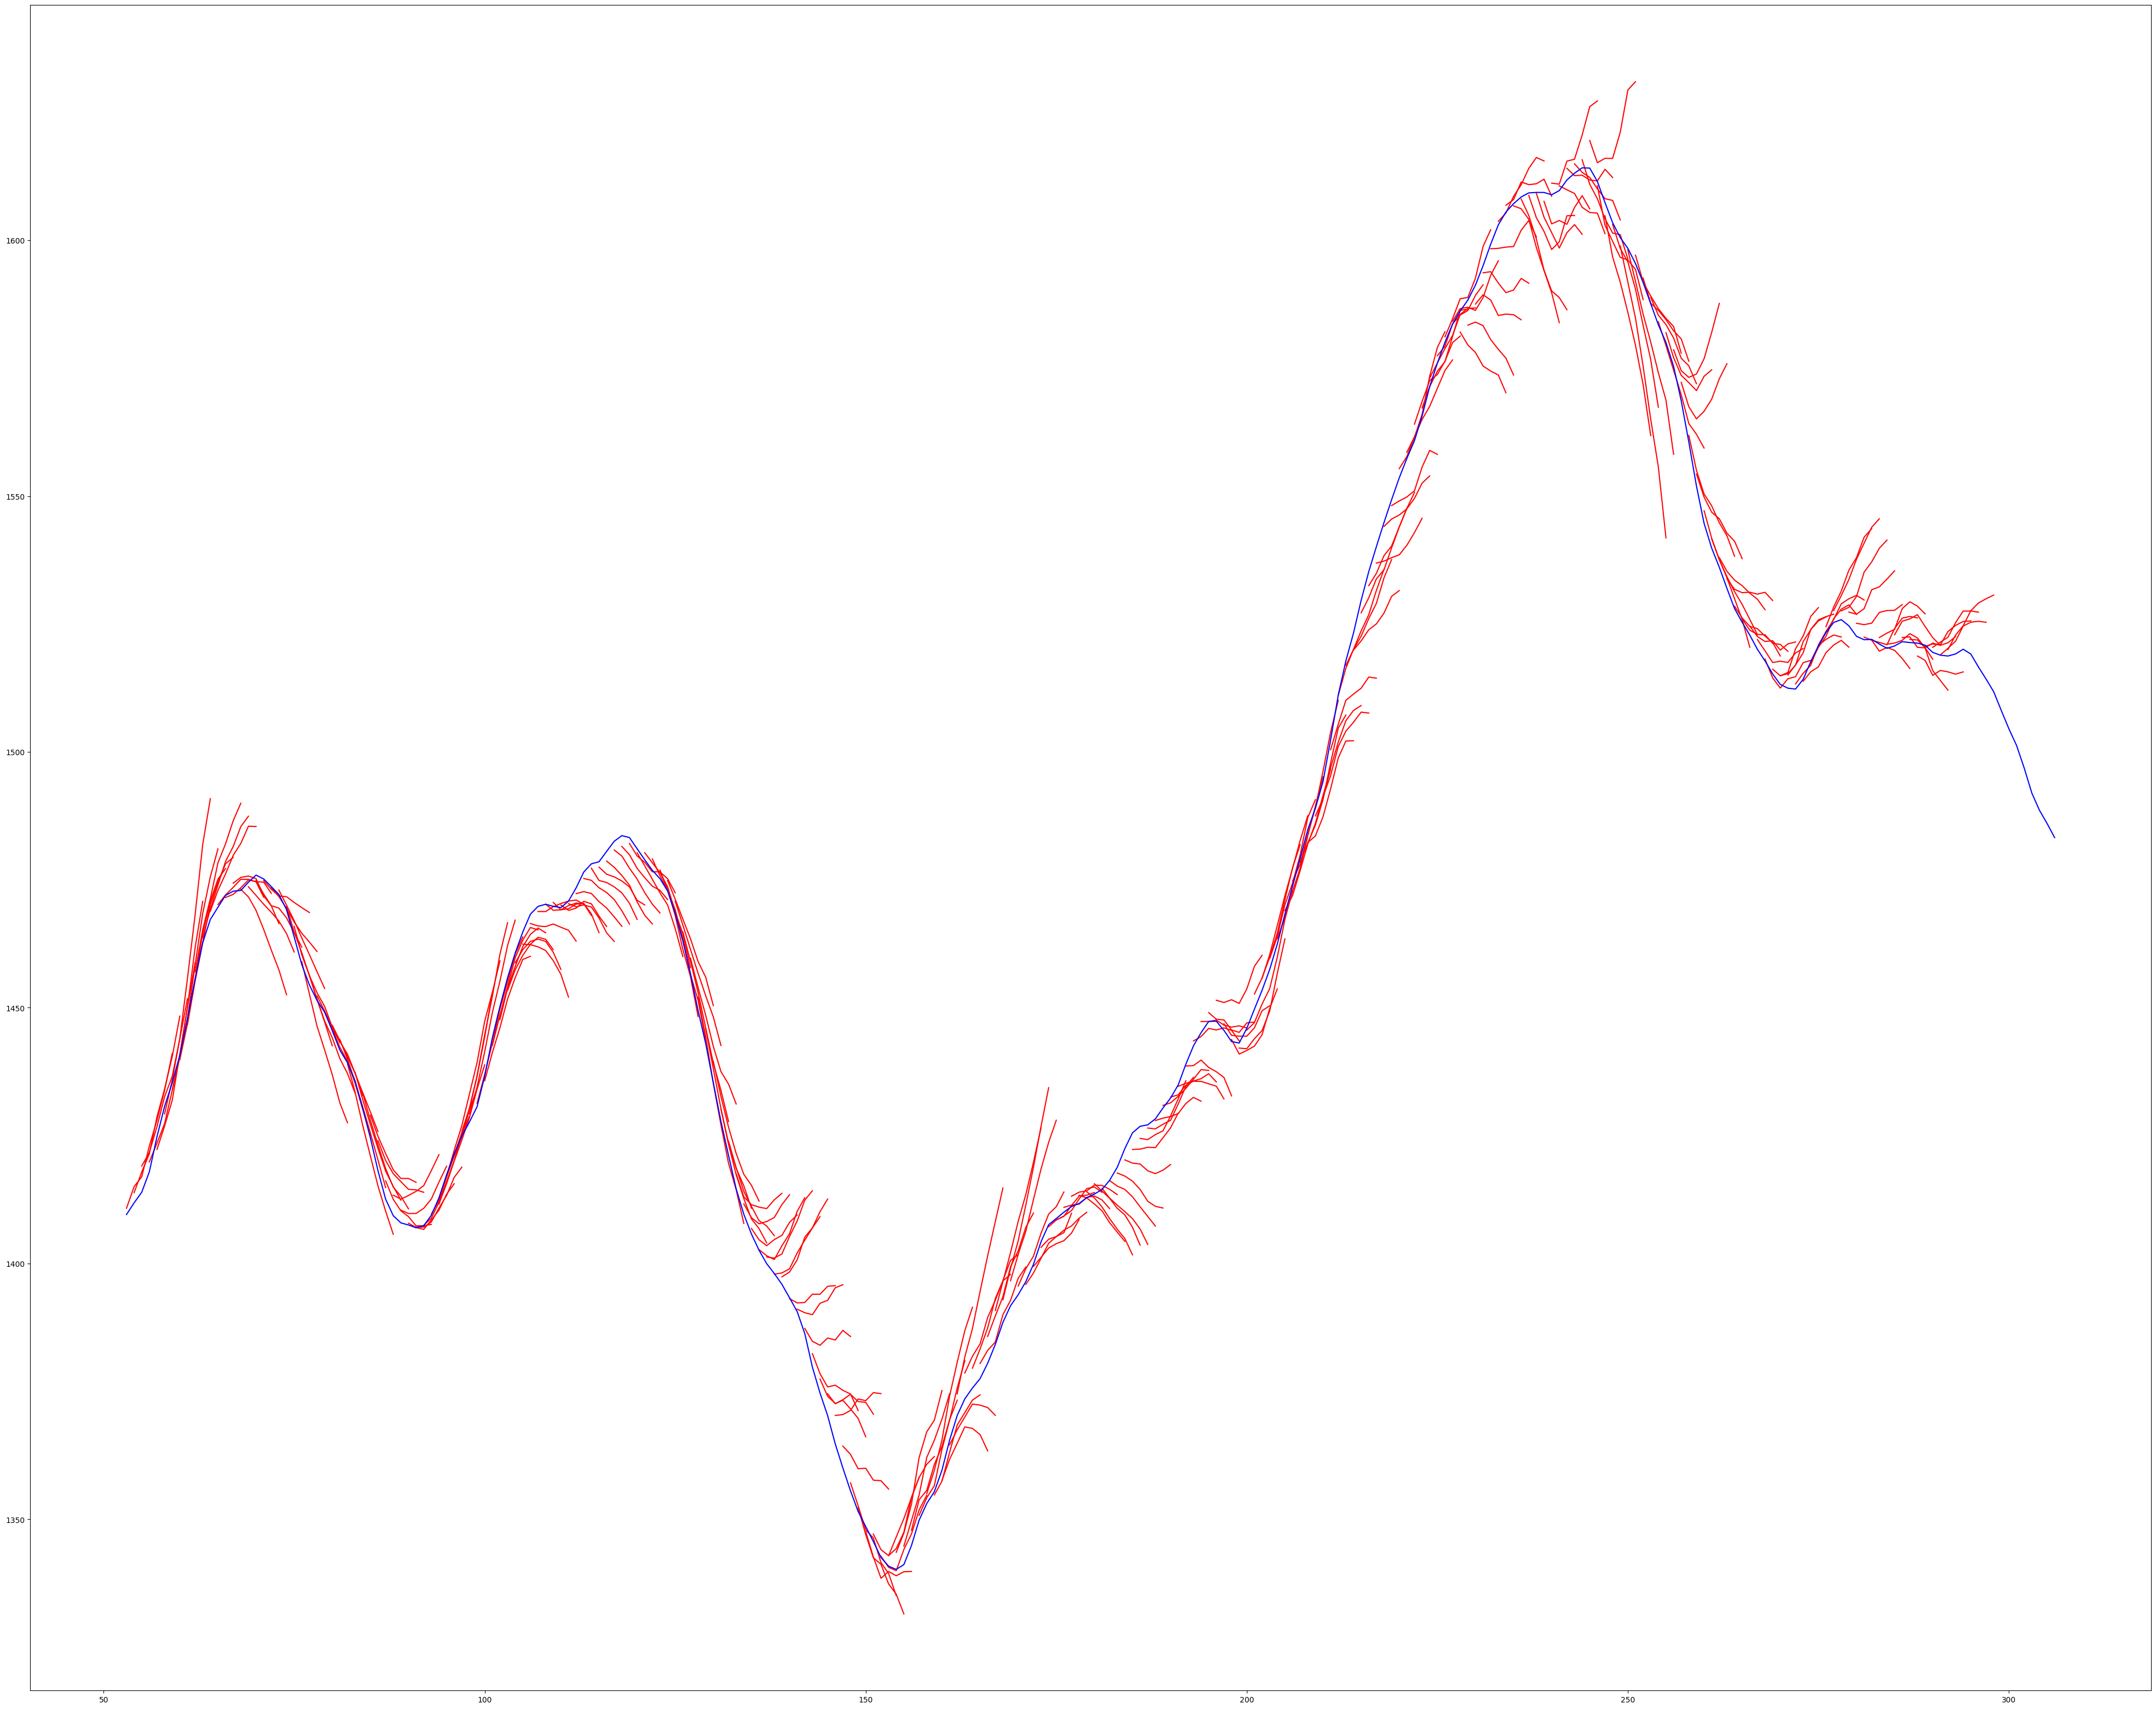

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

for i in range(240):
    plt.plot(data_backup.index[i+(input_period+output_step):i+period], trend_predictions_test[i][0], color='red')

plt.plot(trends_test_df[0].iloc[46:300], color='blue')